1. Load data
2. Preprocessing
3. Train test split
4. Normalization
5. Dataloader
6. Building the model
7. Training loop
8. Test loop and evaluation
9. Plotting

In [ ]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/mssmartypants/rice-type-classification")

In [5]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
original_df = pd.read_csv("/content/rice-type-classification/riceClassification.csv")
original_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
original_df.dropna(inplace=True)
original_df.drop(['id'], axis=1, inplace=True)
print(original_df.head())
print(original_df['Class'].unique())
print(original_df.shape)

   Area  MajorAxisLength  MinorAxisLength  Eccentricity  ConvexArea  \
0  4537        92.229316        64.012769      0.719916        4677   
1  2872        74.691881        51.400454      0.725553        3015   
2  3048        76.293164        52.043491      0.731211        3132   
3  3073        77.033628        51.928487      0.738639        3157   
4  3693        85.124785        56.374021      0.749282        3802   

   EquivDiameter    Extent  Perimeter  Roundness  AspectRation  Class  
0      76.004525  0.657536    273.085   0.764510      1.440796      1  
1      60.471018  0.713009    208.317   0.831658      1.453137      1  
2      62.296341  0.759153    210.012   0.868434      1.465950      1  
3      62.551300  0.783529    210.657   0.870203      1.483456      1  
4      68.571668  0.769375    230.332   0.874743      1.510000      1  
[1 0]
(18185, 11)


In [8]:
X = np.array(original_df.iloc[:,:-1])
Y = np.array(original_df.iloc[:,-1])

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,test_size=0.5)

X_train.shape, X_test.shape, X_val.shape

((12729, 10), (2728, 10), (2728, 10))

In [9]:
X_train /= abs(X_train).max()
X_test /= abs(X_train).max()
X_val /= abs(X_train).max()

In [10]:
class dataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.Y = torch.tensor(Y, dtype=torch.float32).to(device)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    return self.X[index], self.Y[index]


training_data = dataset(X_train, y_train)
testing_data = dataset(X_test, y_test)
validation_data = dataset(X_val, y_val)

In [11]:
BATCH_SIZE = 32
EPOCHS = 30
HIDDEN_NEURONS = 10
LR = 1e-2

In [12]:
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()

    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)

    return x

In [14]:
model = MyModel().to(device)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [15]:
criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)

In [16]:
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(EPOCHS):
    train_loss = 0.0
    train_acc = 0.0
    model.train()  # Set the model to training mode
    for i, data in enumerate(train_dataloader):
        inputs, labels = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        predicted_labels = (outputs > 0.5).float()
        train_acc += accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())


    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation during validation
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()

            predicted_labels = (outputs > 0.5).float()
            val_acc += accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())


    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/30 | Train Loss: 0.3342 | Train Acc: 0.8861 | Val Loss: 55.4869 | Val Acc: 0.4451
Epoch 2/30 | Train Loss: 0.1984 | Train Acc: 0.9226 | Val Loss: 55.1599 | Val Acc: 0.4484
Epoch 3/30 | Train Loss: 0.1905 | Train Acc: 0.9273 | Val Loss: 55.3779 | Val Acc: 0.4462
Epoch 4/30 | Train Loss: 0.1842 | Train Acc: 0.9283 | Val Loss: 55.0509 | Val Acc: 0.4495
Epoch 5/30 | Train Loss: 0.1806 | Train Acc: 0.9293 | Val Loss: 55.0509 | Val Acc: 0.4495
Epoch 6/30 | Train Loss: 0.1770 | Train Acc: 0.9315 | Val Loss: 55.0509 | Val Acc: 0.4495
Epoch 7/30 | Train Loss: 0.1696 | Train Acc: 0.9336 | Val Loss: 54.9419 | Val Acc: 0.4506
Epoch 8/30 | Train Loss: 0.1652 | Train Acc: 0.9356 | Val Loss: 54.9419 | Val Acc: 0.4506
Epoch 9/30 | Train Loss: 0.1607 | Train Acc: 0.9375 | Val Loss: 55.3779 | Val Acc: 0.4462
Epoch 10/30 | Train Loss: 0.1535 | Train Acc: 0.9419 | Val Loss: 55.1599 | Val Acc: 0.4484
Epoch 11/30 | Train Loss: 0.1433 | Train Acc: 0.9454 | Val Loss: 55.0509 | Val Acc: 0.4495
Epoch 12

In [17]:
# Test loop and evaluation
test_loss = 0.0
test_acc = 0.0
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation during testing
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        test_loss += loss.item()

        predicted_labels = (outputs > 0.5).float()
        test_acc += accuracy_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Test Loss: 1.4172 | Test Acc: 0.9858


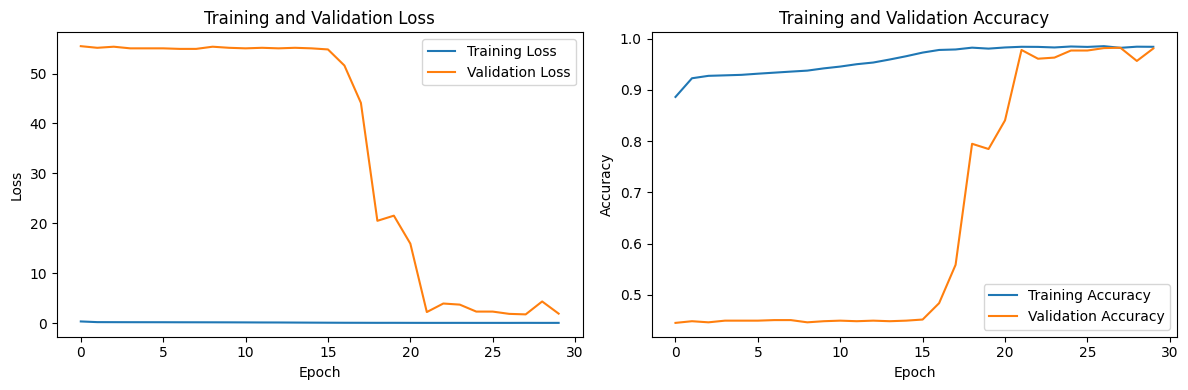

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training and validation loss
axes[0].plot(train_loss_list, label='Training Loss')
axes[0].plot(val_loss_list, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()

# Plot training and validation accuracy
axes[1].plot(train_acc_list, label='Training Accuracy')
axes[1].plot(val_acc_list, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

In [19]:
new_data_point = np.array([[10,20,3,44,112,32,21.1,1,4,5]]) # Replace with your actual data

# Preprocess the new data point (e.g., normalization) using the same method as your training data
new_data_point /= abs(X_train).max()

# Convert to a PyTorch tensor and move it to the device
new_data_point_tensor = torch.tensor(new_data_point, dtype=torch.float32).to(device)

# Set the model to evaluation mode
model.eval()

# Make the prediction without calculating gradients
with torch.no_grad():
  prediction = model(new_data_point_tensor)

# The 'prediction' variable will contain the model's output (a probability between 0 and 1).
# You can interpret it as the probability of belonging to class 1.
# For example:
if prediction > 0.5:
  print("Predicted class: 1")
else:
  print("Predicted class: 0")

# You can also print the raw probability:
print(f"Prediction probability: {prediction.item()}")


Predicted class: 1
Prediction probability: 1.0
